In [31]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
import cftime
from scipy.stats import t

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = '/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/'
out_path_data = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data/'

In [2]:
ds = xr.open_dataset('/work/Katherine.Turner/smaller_projects/hifreq-variability/data/CM4_cmip_monthly_storms.nc', use_cftime=True)

In [3]:
storms_seasonal = ds.center_counts.resample(time='QS-DEC').sum()
idx_jja = storms_seasonal.time.dt.month == 6
idx_djf = storms_seasonal.time.dt.month == 12

storms_djf = storms_seasonal[idx_djf][1:-1]
storms_jja = storms_seasonal[idx_jja]

## correlations with SST

In [25]:
var = 'tos'
ds_v = xr.open_mfdataset(f'/work/Katherine.Turner/tempest-extremes/CM4_cmip/data/*{var}.nc', use_cftime=True)

da_v = ds_v[var].resample(time='QS-DEC').mean()

vidx_djf = da_v.time.dt.month == 12
vidx_jja = da_v.time.dt.month == 6

v_djf = da_v[vidx_djf,:,:][1:-1,:,:]
v_jja = da_v[vidx_jja,:,:]

In [37]:
r_djf = xr.corr(storms_djf, v_djf, dim="time").compute()
r_jja = xr.corr(storms_jja, v_jja, dim="time").compute()

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [45]:
def storm_corr(storm_data, var_data, nyears):
    r = xr.corr(storm_data, var_data, dim='time')
    t_stat = r * np.sqrt((nyears - 2) / (1 - r**2))
    
    pval = xr.apply_ufunc(
        lambda x: 2 * t.sf(np.abs(x), df=nyears - 2),
        t_stat,
        input_core_dims=[[]],
        output_core_dims=[[]],
        vectorize=True,
        dask="allowed"
    )
    
    return r, pval

In [50]:
r_djf, pval_djf = storm_corr(storms_djf, v_djf, 499)
r_jja, pval_jja = storm_corr(storms_jja, v_jja, 500)

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [51]:
# Mask for hatching for non-significant areas
sig_mask_djf = pval_djf < 0.10
sig_mask_jja = pval_jja < 0.10

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


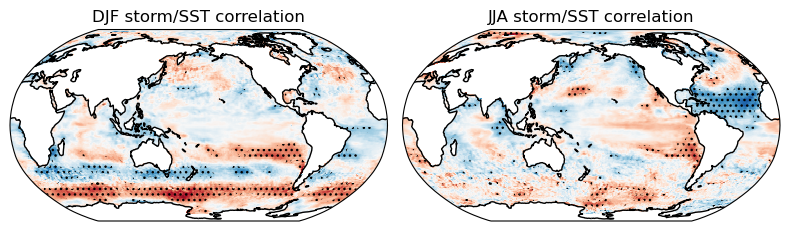

In [53]:
proj = ccrs.Robinson(central_longitude=180)  # or another if you're using rotated pole etc.

fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize=(8, 5), 
                       subplot_kw={'projection': proj})

# Plot the correlation field
ax[0].pcolormesh(
    r_djf.lon, r_djf.lat, r_djf,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-.2, vmax=.2
)
ax[0].set_title('DJF storm/SST correlation')

ax[0].contourf(
    r_djf.lon, r_djf.lat, sig_mask_djf,
    levels=[0.5, 1],
    hatches=['...', None],
    colors='none',
    transform=ccrs.PlateCarree()
)

ax[1].pcolormesh(
    r_jja.lon, r_jja.lat, r_jja,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-.2, vmax=.2
)
ax[1].set_title('JJA storm/SST correlation')

ax[1].contourf(
    r_jja.lon, r_jja.lat, sig_mask_jja,
    levels=[0.5, 1],
    hatches=['...', None],
    colors='none',
    transform=ccrs.PlateCarree()
)

for i in range(2):
    ax[i].coastlines()

plt.tight_layout()
#plt.show()

## Soft weighting approach (try to emphasize extreme storm years)

In [64]:
weights_djf = (storms_djf - storms_djf.mean())**2
weights_djf = weights_djf / weights_djf.sum()

weights_jja = (storms_jja - storms_jja.mean())**2
weights_jja = weights_jja / weights_jja.sum()

In [65]:
def storm_corr_weighted(storm_data, var_data, weights):
    storm_wmean = (weights * storm_data).sum(dim='time')
    var_wmean = (weights * var_data).sum(dim='time')
    
    storm_wanom = storm_data - storm_wmean
    var_wanom = var_data - var_wmean
    
    num = (weights * storm_wanom * var_wanom).sum(dim='time')
    denom = np.sqrt((weights * storm_wanom**2).sum(dim='time') * 
                    (weights * var_wanom**2).sum(dim='time')
                   )
    
    r_weighted = num / denom
    
    return r_weighted

In [66]:
r_djf_w2 = storm_corr_weighted(storms_djf, v_djf, weights_djf)
r_jja_w2 = storm_corr_weighted(storms_jja, v_jja, weights_jja)

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


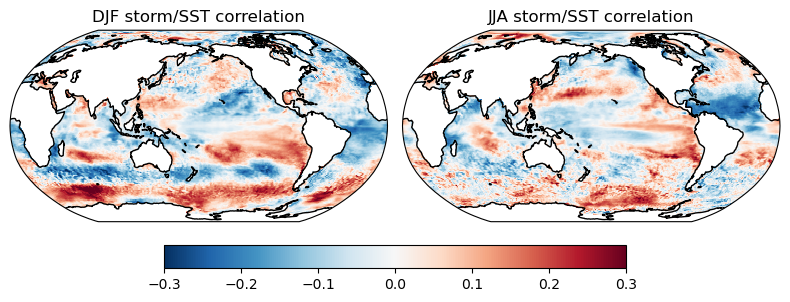

In [78]:
proj = ccrs.Robinson(central_longitude=180)  # or another if you're using rotated pole etc.

fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize=(8, 5), 
                       subplot_kw={'projection': proj})

# Plot the correlation field
ax[0].pcolormesh(
    r_djf.lon, r_djf.lat, r_djf_w2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-.3, vmax=.3
)
ax[0].set_title('DJF storm/SST correlation')

f = ax[1].pcolormesh(
    r_jja.lon, r_jja.lat, r_jja_w2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-.3, vmax=.3
)
ax[1].set_title('JJA storm/SST correlation')

for i in range(2):
    ax[i].coastlines()

plt.tight_layout()
fig.colorbar(f,ax=ax[:], shrink=0.6, pad=0.05, location='bottom')

plt.savefig(f"{out_path_fig}/CM4_cmip_storm_tos_sqw_corr.png", format='png', dpi=100)

In [97]:
a = storms_djf 
b = v_djf

# Compute weighted means
mean_a = (a * weights_djf).sum(dim='time')
mean_b = (b * weights_djf).sum(dim='time')

In [98]:
# Compute weighted covariance and variances
cov_ab = ((a - mean_a) * (b - mean_b) * summer_weights).sum(dim='time')
var_a = ((a - mean_a)**2 * summer_weights).sum(dim='time')
var_b = ((b - mean_b)**2 * summer_weights).sum(dim='time')

r_sqweighted = cov_ab / np.sqrt(var_a * var_b)

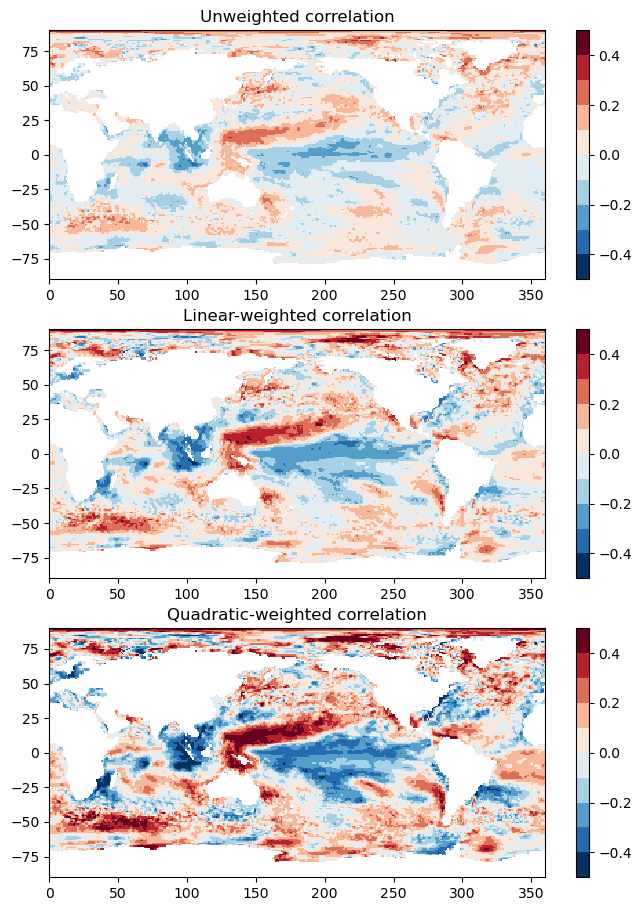

In [103]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,11))

r_unweighted.plot(ax=axs[0], vmin=-.5, vmax=.5, extend='neither', cmap=plt.get_cmap("RdBu_r",10))
axs[0].set_title('Unweighted correlation')
r_weighted.plot(ax=axs[1], vmin=-.5, vmax=.5, extend='neither', cmap=plt.get_cmap("RdBu_r",10))
axs[1].set_title('Linear-weighted correlation')
r_sqweighted.plot(ax=axs[2], vmin=-.5, vmax=.5, extend='neither', cmap=plt.get_cmap("RdBu_r",10))
axs[2].set_title('Quadratic-weighted correlation')

for i in range(3):
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
plt.savefig('/home/Katherine.Turner/Figures/summer_storms_SST_corr_options.png', format='png', dpi=100)

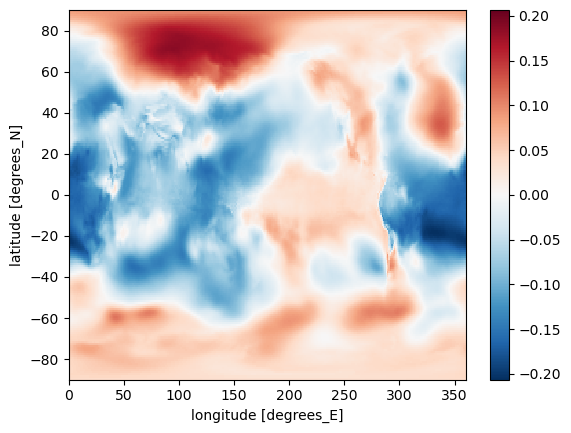

In [81]:
(r_weighted - r_unweighted).plot()